# Airbnb Analytics MVP

This notebook implements a lean Python MVP for Airbnb analytics:
- Optimize pricing
- Visualize the market
- Forecast revenue

Results are exported for integration with Next.js app.

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

: 

In [2]:
# Load data
# Note: Adjust paths if running from different directory
listings_df = pd.read_csv('../src/data/listings.csv')
calendar_df = pd.read_csv('../src/data/calendar.csv')

print('Listings shape:', listings_df.shape)
print('Calendar shape:', calendar_df.shape)
print('\nListings columns:', list(listings_df.columns))
print('\nCalendar columns:', list(calendar_df.columns))

Listings shape: (15187, 79)
Calendar shape: (5635043, 7)

Listings columns: ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availa

In [3]:
# Data preprocessing
# Clean price columns
listings_df['price'] = listings_df['price'].str.replace('$', '').str.replace(',', '').astype(float)
calendar_df['price'] = calendar_df['price'].str.replace('$', '').str.replace(',', '').astype(float)
calendar_df['adjusted_price'] = calendar_df['adjusted_price'].str.replace('$', '').str.replace(',', '').astype(float)

# Convert date
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

# Handle missing values
listings_df = listings_df.dropna(subset=['price'])
calendar_df = calendar_df.dropna(subset=['price'])

print('Cleaned listings shape:', listings_df.shape)
print('Cleaned calendar shape:', calendar_df.shape)

Cleaned listings shape: (10708, 79)
Cleaned calendar shape: (5635043, 7)


## Pricing Optimization

Use linear regression to predict optimal price based on property features.

In [4]:
# Prepare features for pricing model
features = ['accommodates', 'bedrooms', 'bathrooms', 'beds', 'minimum_nights', 'maximum_nights']
X = listings_df[features].fillna(0)
y = listings_df['price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'RMSE: ${rmse:.2f}')
print('Model coefficients:')
for feature, coef in zip(features, model.coef_):
    print(f'{feature}: ${coef:.2f}')

RMSE: $2307.32
Model coefficients:
accommodates: $-0.51
bedrooms: $-77.04
bathrooms: $169.84
beds: $13.37
minimum_nights: $-4.82
maximum_nights: $0.73


## Market Visualization

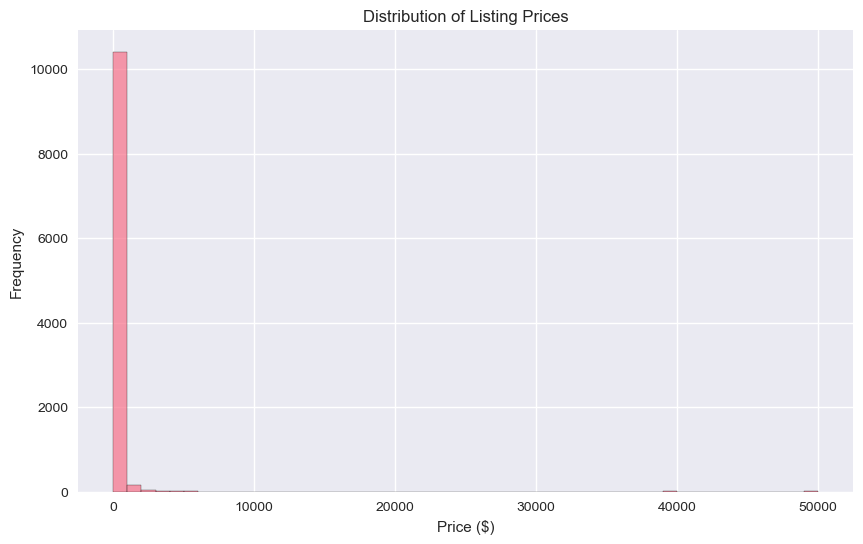

In [5]:
# Price distribution
plt.figure(figsize=(10, 6))
plt.hist(listings_df['price'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Listing Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()

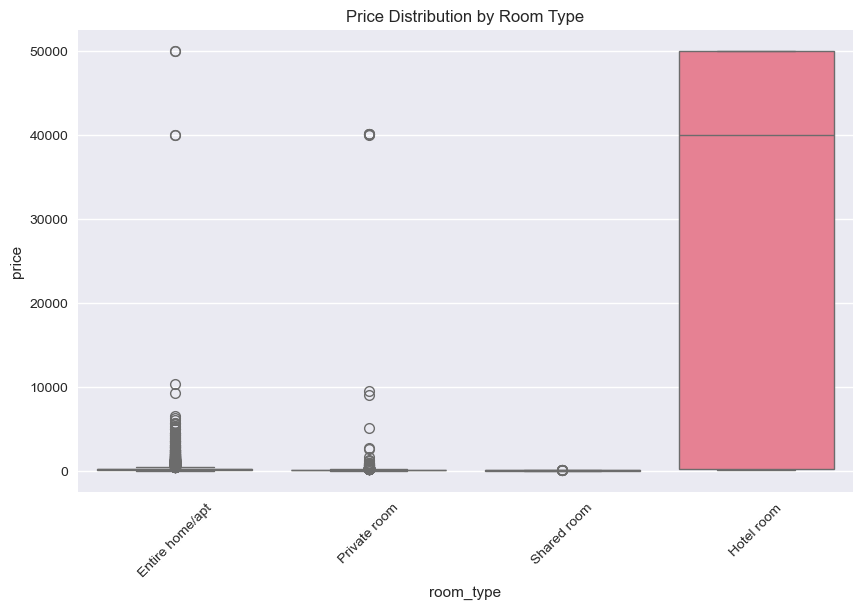

In [6]:
# Price by room type
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price', data=listings_df)
plt.title('Price Distribution by Room Type')
plt.xticks(rotation=45)
plt.show()

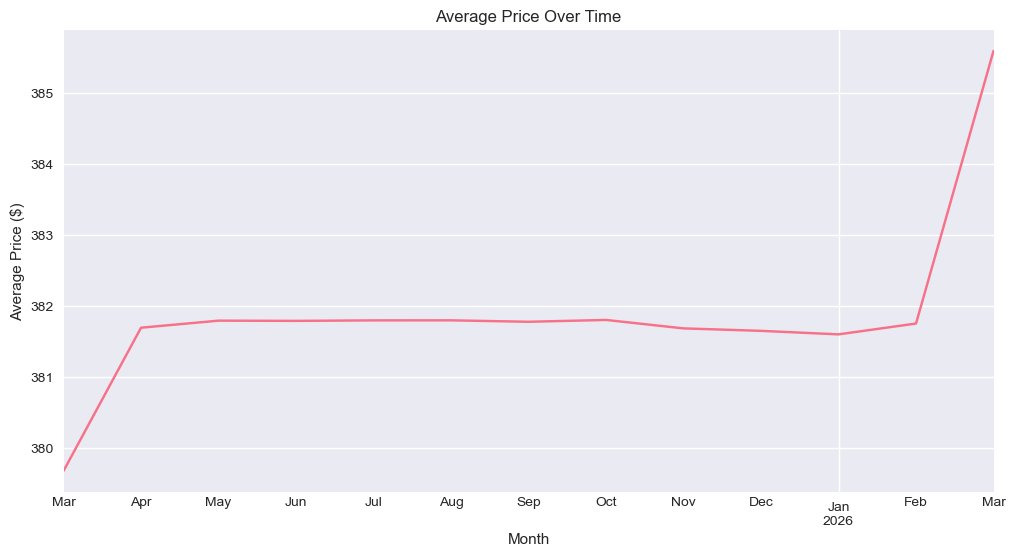

In [7]:
# Average price over time
monthly_avg = calendar_df.groupby(calendar_df['date'].dt.to_period('M'))['price'].mean()

plt.figure(figsize=(12, 6))
monthly_avg.plot()
plt.title('Average Price Over Time')
plt.xlabel('Month')
plt.ylabel('Average Price ($)')
plt.show()

## Revenue Forecasting

Simple forecasting based on historical occupancy and pricing.

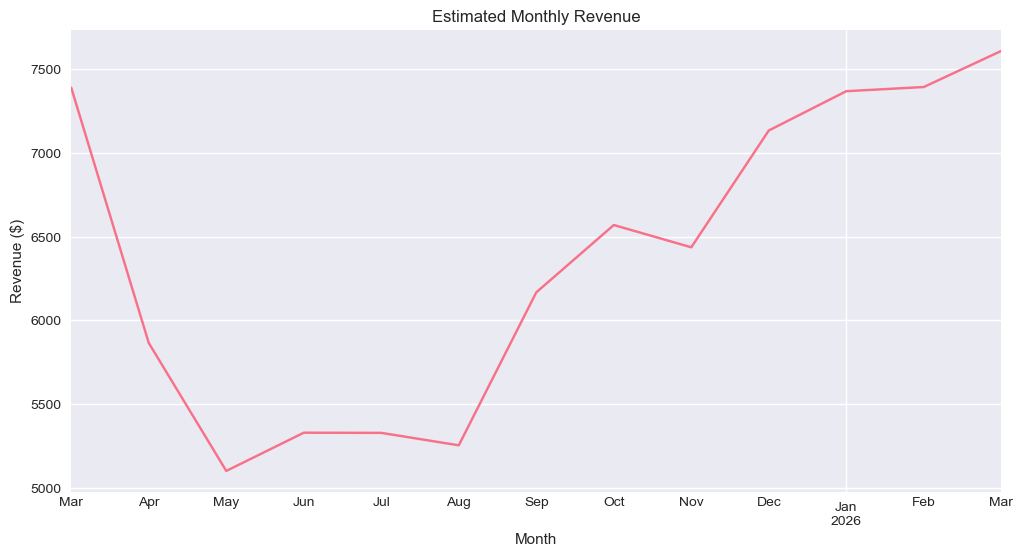

Average monthly revenue: 6379.888244498617


In [8]:
# Calculate occupancy rate
calendar_df['occupied'] = calendar_df['available'] == 'f'
occupancy_rate = calendar_df.groupby(calendar_df['date'].dt.to_period('M'))['occupied'].mean()

# Calculate potential revenue
monthly_revenue = monthly_avg * occupancy_rate * 30  # Assuming 30 days per month

plt.figure(figsize=(12, 6))
monthly_revenue.plot()
plt.title('Estimated Monthly Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue ($)')
plt.show()

print('Average monthly revenue:', monthly_revenue.mean())

## Export Results for Next.js Integration

In [9]:
# Export key metrics to JSON
results = {
    'average_price': listings_df['price'].mean(),
    'median_price': listings_df['price'].median(),
    'total_listings': len(listings_df),
    'occupancy_rate': occupancy_rate.mean(),
    'average_monthly_revenue': monthly_revenue.mean(),
    'pricing_model_rmse': rmse,
    'model_coefficients': dict(zip(features, model.coef_))
}

import json
with open('analytics_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print('Results exported to analytics_results.json')
print(json.dumps(results, indent=2))

Results exported to analytics_results.json
{
  "average_price": 386.4705827418752,
  "median_price": 138.0,
  "total_listings": 10708,
  "occupancy_rate": 0.5568543967930211,
  "average_monthly_revenue": 6379.888244498617,
  "pricing_model_rmse": 2307.3156739617452,
  "model_coefficients": {
    "accommodates": -0.5130832104580475,
    "bedrooms": -77.03896771426807,
    "bathrooms": 169.84011117249764,
    "beds": 13.372764139911048,
    "minimum_nights": -4.822931202172335,
    "maximum_nights": 0.73464256867382
  }
}


In [10]:
# Export processed data for visualization
listings_export = listings_df[['id', 'name', 'room_type', 'price', 'accommodates', 'bedrooms', 'bathrooms']].head(100)
listings_export.to_csv('listings_sample.csv', index=False)

calendar_export = calendar_df.groupby(calendar_df['date'].dt.to_period('M')).agg({
    'price': 'mean',
    'occupied': 'mean'
}).reset_index()
calendar_export['date'] = calendar_export['date'].astype(str)
calendar_export.to_csv('monthly_stats.csv', index=False)

print('Sample data exported for Next.js integration')

Sample data exported for Next.js integration
